In [3]:
from scipy.io import loadmat
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [4]:
mat = loadmat('data/example1kinect.mat')

In [5]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Apr 26 16:26:46 2017',
 '__version__': '1.0',
 '__globals__': [],
 'amplitudes1': array([[    0,  1711,  2618, ..., 11774, 17148,     0],
        [    0,  3487,  3862, ...,  6204,  6588,     0],
        [    0,  2883,  1739, ...,  6702,  7729,     0],
        ...,
        [    0,  9210,  7708, ...,  4909,  4566,     0],
        [    0, 17712, 13374, ...,  9831,  7632,     0],
        [    0, 33642, 16712, ...,  6590,  7424,     0]], dtype=uint16),
 'distances1': array([[0.        , 0.        , 0.        , ..., 2.08750653, 9.91966915,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 2.21158051, 0.        ,
         0.        ],
        ...,
        [0.        , 0.81849653, 0.8396064 , ..., 0.86473584, 0.88194507,
         0.        ],
        [0.        , 0.87757653, 0.8493191 , ..., 0.84469038, 0.

In [6]:
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'amplitudes1', 'distances1', 'cloud1'])


In [7]:
A = mat['amplitudes1']  
D = mat['distances1'] 
PC = mat['cloud1']    

In [8]:
A.shape

(424, 512)

In [9]:
D.shape

(424, 512)

In [10]:
PC.shape

(424, 512, 3)

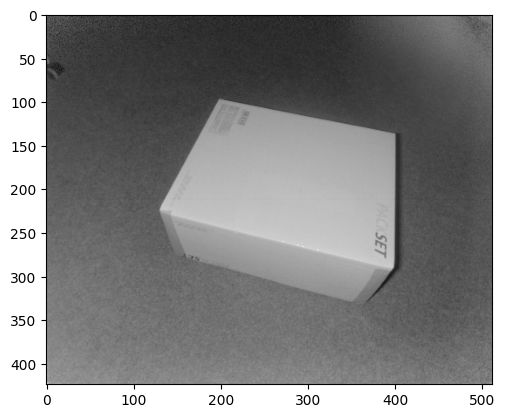

In [27]:
plt.imshow(A, norm='log', cmap='gray')

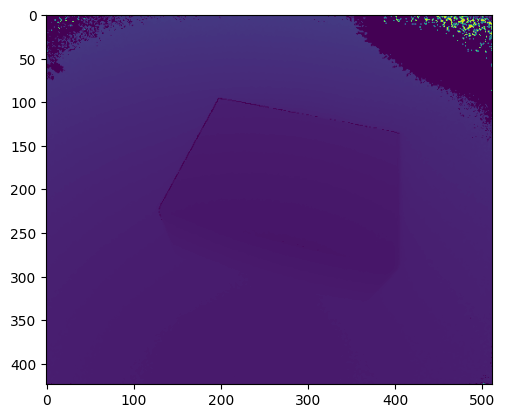

In [30]:
plt.imshow(D, norm='linear')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0650511980056763..1.8000001907348633].


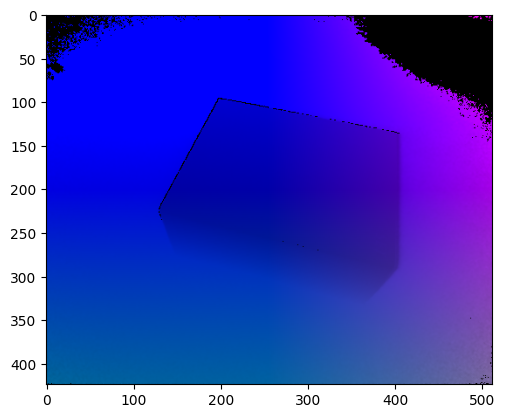

In [31]:
plt.imshow(PC)

In [32]:
x = PC[:, :, 0]
y = PC[:, :, 1]
z = PC[:, :, 2]

In [33]:
x.shape

(424, 512)

In [34]:
x_flat = x.ravel() 
y_flat = y.ravel()
z_flat = z.ravel()

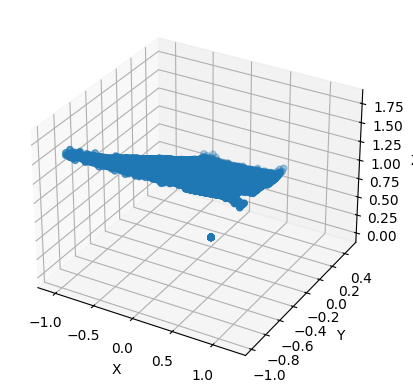

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_flat, ys=y_flat, zs=z_flat)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [36]:
subsample_percentage = 1

In [37]:
n = len(x_flat)
subsample_size = int(n * (subsample_percentage / 100))
indices = np.random.choice(n, subsample_size, replace=False)

In [38]:
x_sub = x_flat[indices]
y_sub = y_flat[indices]
z_sub = z_flat[indices]

In [39]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_sub, ys=y_sub, zs=z_sub)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()